In [1]:
import torch
import tqdm

from hydra import initialize, compose
from hydra.utils import instantiate
from pytorch_lightning.utilities import move_data_to_device

from bliss.surveys.dc2 import DC2DataModule
from case_studies.dc2_diffusion.utils.catalog_parser import CatalogParser
from bliss.catalog import TileCatalog
from bliss.global_env import GlobalEnv

import matplotlib.pyplot as plt

from case_studies.dc2_new_diffusion.utils.autoencoder import CatalogEncoder, CatalogDecoder

In [2]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
with initialize(config_path=".", version_base=None):
    new_diffusion_notebook_cfg = compose("latent_diffusion_notebook_config")

In [3]:
tile_slen = new_diffusion_notebook_cfg.surveys.dc2.tile_slen
max_sources_per_tile = new_diffusion_notebook_cfg.surveys.dc2.max_sources_per_tile
r_band_min_flux = new_diffusion_notebook_cfg.notebook_var.r_band_min_flux

dc2: DC2DataModule = instantiate(new_diffusion_notebook_cfg.surveys.dc2)
dc2.batch_size = 1024
dc2.setup(stage="fit")
GlobalEnv.current_encoder_epoch = 1
GlobalEnv.seed_in_this_program = 7272
dc2_val_dataloader = dc2.val_dataloader()

catalog_parser: CatalogParser = instantiate(new_diffusion_notebook_cfg.encoder.catalog_parser)

In [4]:
target_ch = catalog_parser.n_params_per_source
encoder = CatalogEncoder(target_ch, hidden_dim=32)
decoder = CatalogDecoder(target_ch, hidden_dim=32 // 4)

In [5]:
encoder = encoder.to(device=device)
decoder = decoder.to(device=device)

In [6]:
encoder_weights = torch.load("encoder.pt", map_location=device)
decoder_weights = torch.load("decoder.pt", map_location=device)
encoder.load_state_dict(encoder_weights)
decoder.load_state_dict(decoder_weights)
encoder.eval()
decoder.eval()

CatalogDecoder(
  (decoder): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (norm): GroupNorm(1, 8, eps=1e-05, affine=True)
      (activation): SiLU(inplace=True)
    )
    (1): ConvBlock(
      (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (norm): GroupNorm(2, 16, eps=1e-05, affine=True)
      (activation): SiLU(inplace=True)
    )
    (2): C3(
      (cv1): ConvBlock(
        (conv): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm): GroupNorm(1, 8, eps=1e-05, affine=True)
        (activation): SiLU(inplace=True)
      )
      (cv2): ConvBlock(
        (conv): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm): GroupNorm(1, 8, eps=1e-05, affine=True)
        (activation): SiLU(inplace=True)
      )
      (cv3): ConvBlock(
        (conv): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (nor

In [7]:
encoder_outputs = []
for batch in tqdm.tqdm(dc2_val_dataloader):
    batch = move_data_to_device(batch, device=device)
    target_tile_cat = TileCatalog(batch["tile_catalog"])
    target_tile_cat = target_tile_cat.get_brightest_sources_per_tile(band=2,  exclude_num=0)
    target_full_cat = target_tile_cat.to_full_catalog(tile_slen)

    encoded_catalog_tensor = catalog_parser.encode(target_tile_cat).permute([0, 3, 1, 2])  # (b, k, h, w)
    with torch.no_grad():
        encoder_pred = encoder(encoded_catalog_tensor)
    #     recovered_target = decoder(encoder_pred)
    # recovered_target = catalog_parser.clip_tensor(recovered_target.permute([0, 2, 3, 1]))
    # recovered_tile_cat = catalog_parser.decode(recovered_target)
    # recovered_full_cat = recovered_tile_cat.to_full_catalog(tile_slen)
    encoder_outputs.append(encoder_pred.flatten().cpu())

100%|██████████| 25/25 [00:15<00:00,  1.63it/s]


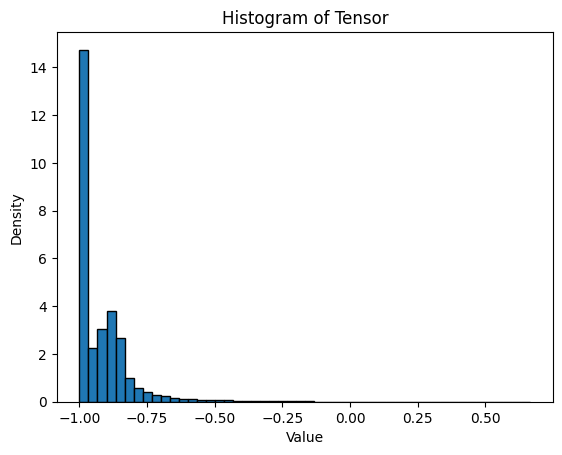

In [10]:
plt.hist(torch.stack(encoder_outputs[:-1]).flatten().numpy() / 9 * 2 - 1, 
         bins=50, density=True, edgecolor="black")
plt.title("Histogram of Tensor")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()